#### Ahora mismo:
- Tratamiento de BBDD
    - Coger las imágenes y dividirlas en 4 (con solapamiento que sea). En principio se van a hacer con las pares y las impares pero guardándolas en directorios distintos por si acaso luego tenemos que recurrir a las impares. Al hacer el parche tanto de la imagen como de su máscara, comprobamos el porcentaje de información que tiene la máscara. Si no tiene, la desechamos.
- Índice de la memoria + parte teórica
- Implementación de SmoothGradCAM++

#### Pasos siguientes:
- Entrenamiento de los clasificadores en BBDD-tratado
- Explicación con CAM, GradCAM, GradCAM++ y SmoothGradCAM++ con los modelos entrenados
- Análisis de resultados

#### Hecho:
- Modularizar CAM
- Implementación CAM y gradCAM
- Selección de clasificadores (torch.models) (VGG, ResNet, Inception, MobileNet)
- Modularizar GradCAM
- Implementar y modularizar GradCAM++


#### Notas:
##### nuevas
- En el paper de SmoothGradCAM, en los pesos alpha_i_j se pone la PRIMERA derivada en el numerador (GradCAM++ pone la segunda derivada)

##### Antiguas
- Estaba teniendo un problema y era que GradCAM++ hacía unos saliency maps raros. Por ejemplo, la foto de un PERRO. El heatmap del gato marcaba muchas veces al perro como verde (aún no sé bien por qué) y en el perro pasaba lo mismo. Se podía ver como en el heatmap del gato, los valores máximos y mínimos que alcanzaban los heatmax estaban entre -100 y 100 (aprox). Sin embargo, en el heatmap del perro, se marcaban tb las mismas zonas, pero los valores que aparecían eran gigantes y positivos (del orden de 1e5).

    me he dado cuenta de que quitando la activación relu de los pesos W, el dibujo ya salía bien al menos, y me he dado cuenta de por qué estaba esa ReLU: únicamente deja pasar los valores que contribuyen, y creo que es una forma de "contar" los píxeles que aportan de manera parecida a lo que hacen en el apartado de intuición. 
    Este píxel aporta su **importancia multiplicada por el alpha, y el alpha nos damos cuenta de que en el denominador tiene la suma del área. Así en cierto modo se hace: Importancia/(1+Area*importancia) ~ 1/(1+Area)**

In [498]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

import os

import time
import os
import copy
import math

import cv2


import abc  # For implementing abstract methods


# Reset CUDA cache
torch.cuda.empty_cache()

# Define colormap
colors = [(1, 0, 0), (0, 0, 1),  (0, 1, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'good_vs_evil'
cmap_good_vs_evil = LinearSegmentedColormap.from_list(cmap_name, colors)


## FUNCIONES ÚTILES GENERALES

In [499]:
def remove_modules_type(module, types_module):
    """
    Parameters:
    -----------
    module: nn.Module
      Module where we want to remove {type_module} modules.

    types_module: list of class which inherits from nn.Module
      Types to remove.

    Description:
    ------------
    This function remove all {type_module} modules from
    a first module: {module}

    Return:
    -------
    List of nn.Module
    """
    presence_type = False
    mod_without_type = []
    out_channels = -1
    
    # Prueba:
    in_features_channels = []  # input of the module we are removing
    
    for m in module.children():
        # Test the type
        for type_module in types_module:
            if isinstance(m, type_module) and not presence_type:
                presence_type = True
                try:
                    # If it's Linear
                    in_features_channels.append(m.in_features)
                except:
                    try:
                        # If it's Conv2d
                        in_features_channels.append(m.in_channels)
                    except:
                        # Other cases are not considered
                        in_features_channels = in_features_channels

                break

        if presence_type:
            return mod_without_type, in_features_channels
        
        elif isinstance(m, nn.Sequential):
            # If it's sequential
            modules_removed, in_features_channels_new = remove_modules_type(m, [nn.Linear])
            in_features_channels = in_features_channels + in_features_channels_new

            if len(modules_removed)>0:
                mod_without_type.append(nn.Sequential(*modules_removed))
        else:
            mod_without_type.append(m)
            

    return mod_without_type, in_features_channels


############################################################################
# ENTRENAMIENTO
############################################################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, device='cuda'):
    since = time.time()

    # Saving actual weights as best weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' %(epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                scheduler.step()
            elif phase == 'val' and epoch_loss < best_loss:
                # deep copy the model
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_loss, best_acc





In [500]:
model_vgg = models.vgg16(pretrained=True)
#print(model_vgg)



## PRUEBA DE CAPAS

In [501]:
# With default parameters
flat = nn.Flatten()

# pool of non-square window
m = nn.AdaptiveAvgPool2d(output_size=(1))
lin = nn.Linear(in_features=512, out_features = 4096, bias = True)
mm = nn.AvgPool2d(20)
l=[]
for i in range(20):
  row=[]
  for j in range(20):
    row.append(float(20*i+j))
  l.append(row)


arr=np.array([l])
input = torch.from_numpy(arr)
input = torch.rand(512,30,30)
input = torch.randn(32, 1, 5, 5)

"""
# Ejecutamos los pooling
output = m(input)
print(f"tensor:\n {output}\n\nOutput shape: {output.shape}")
output2 = lin(torch.reshape(output, (1,25088)))
print(f"tensor:\n {output2}\n\nOutput shape: {output2.shape}")
"""
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x7 and 25088x4096)

output = m(input)
output_flat = flat(output)

sh = output.shape
#print(f"tensor:\n {output}\n\nOutput shape: {output.shape}, {output_flat.shape}")
#print((torch.reshape(output,(sh[0],sh[1]))==output_flat).all())


# CLASES CAM

### base CAM class (INHERITANCE)

In [502]:
class CAM_abstract:
    __metaclass__ = abc.ABCMeta
    
    @abc.abstractproperty  # Abstract attribute
    def name(self):
        pass

    
    @abc.abstractmethod
    def get_activations(self, x):
        """
        Parameters:
        -----------
            -x: input image (tensor)
            
        Return:
        -------
            activations, the last values before passing
            through the first fully connected layer
        """
        return
    
    @abc.abstractmethod
    def get_weights(self, activations=None, device='cuda'):
        """
        Parameters:
        -----------
            -activations: tensor
                the last values before passing
                through the first fully connected layer
                
            -n_noise: int
                number of noised inputs
            
            -std: desviación para smooth
            
        Return:
        -------
            weights which are used to multiply the activations.
        """        
        return
    
    @abc.abstractmethod
    def get_subweights(self, activations=None, grad=None):
        """
        Parameters:
        -----------
            -activations: tensor
                the last values before passing through
                the first fully connected layer

            -grad: tensor
                activations gradient for GradCAM++.
                None for CAM and GradCAM
                
            
        Return:
        -------
            weights which are used to multiply the gradients.
        """        
        return
    

    def saliency_map(self, x, n_noise=1, std=0, device='cuda'):
        # utils
        soft = nn.Softmax(dim=1)

        # Evaluate mode
        self.eval()

        # We generate the activation map
        activations = self.get_activations(x)
        
        if n_noise>1:
            # Calculate (if it's the case) the noisy activations
            std_tensor = torch.ones_like(activations) * std
            activations_with_noise = torch.tensor([]).to(device)
            
            for n in range(n_noise):
                # Add noise to activation layer
                act_noise = torch.normal(mean=activations, std=std_tensor)
                activations_with_noise = torch.cat((activations_with_noise,act_noise[None,:,:,:,:]))
                
            activations = activations_with_noise # rename in order to reuse the next 'get_weight' function for every case
            
        # Getting the parameters from the first layer of self.fc (the unique layer)
        parameters, y = self.get_weights(activations, device=device)
        
        # Getting the final activations tensor
        activations = activations.mean(axis=0)
        if n_noise>1:
            activations = activations.mean(axis=0)
        
        heatmaps=torch.tensor([]).to(device)
        for class_i in range(self.n_classes):
            # Getting the heatmaps: w_1*Act_1 + w_2*Act_2 +...+ w_n*Act_n activations.shape
            activations_final = ((parameters[class_i]*activations.T).T).sum(axis=0)
   
            heatmaps = torch.cat((heatmaps, activations_final[None,:,:]))

        return heatmaps, y 
    
    def plot_saliency_map(self, x, y, class_plot=-1, n_noise=1, std=0, device='cuda'):
        """
        Parameters:
        -----------
            - x: input 

            - y: {x} actual class

            - class_plot:
                    {-2} to plot all classes
                    {-1} to plot the class predicted
                    {n}  to plot the n-class (n in {0,1,2,...})
                    
            -n_noise: int
                number of noised inputs
        """
        # utils
        soft = nn.Softmax(dim=1)

        mean = [0.485, 0.456, 0.406]
        var = [0.229, 0.224, 0.225]
        x_plot=((torch.reshape(x.cpu(), (3,224,224)).permute(1,2,0).numpy())*var)+mean
    

        
        # Getting the heatmaps
        heatmaps_pre, y_pred = self.saliency_map(x, n_noise=n_noise, std=std, device=device)
        y_prob = soft(y_pred)
    
        heatmaps_new = list()
        
        # Dividimos por el mayor absoluto para tener mapas relativos
        heatmaps_pre = heatmaps_pre / torch.max(torch.abs(heatmaps_pre))
        
        # Visualización
        for hm in heatmaps_pre: 
            print(f'MIN: {hm.min()}, MAX: {hm.max()}')
            heatmaps_new.append(hm.cpu().detach().numpy())

        res=[]
        res.append(cv2.resize(heatmaps_new[0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
        res.append(cv2.resize(heatmaps_new[1], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))

        
        # Taking the class predicted
        print(f"Y: {soft(y_pred)}")
        y_pred_modnew = torch.argmax(soft(y_prob),axis=0)
        dic_prob = {"gato": y_prob[0][0], "perro": y_prob[0][1] }
        
        cam_pred_name = "gato" if y_pred_modnew[0]==0 else "perro"
        cam_act_name = "gato" if y==0 else "perro"

        print('PROB {}:\n\t- GATO: {:.5f}\n\t- PERRO: {:.5f}'.format(self.name, dic_prob["gato"], dic_prob["perro"]))
        print(f'(CLASS PREDICTED -- {cam_pred_name}) vs ({cam_act_name} -- ACTUAL CLASS)')
        
        
        ###########################
        #   HACEMOS PLOT
        plot_hm = np.zeros(self.n_classes)
        for i in range(self.n_classes):
            if class_plot==-2 or (class_plot==-1 and i==y_pred_mod_new) or i==n:
                plot_hm[i]=1
        
                    
        n_cols=int(plot_hm.sum())
        fig, axes = plt.subplots(nrows=1, ncols=n_cols)
        curr_axe = 0
        for i in range(n_cols):
            if plot_hm[i]==1:
                axes[curr_axe].imshow(x_plot)
                im = axes[curr_axe].imshow(res[i],alpha=0.5, vmin=-1, vmax=1, cmap=cmap_good_vs_evil)
                if i==0:
                    axes[curr_axe].title.set_text(f"----------- HEATMAP GATO -----------")
                else:
                    axes[curr_axe].title.set_text(f"----------- HEATMAP PERRO -----------")

                cbar = fig.colorbar(im, ax=axes[curr_axe], ticks=[-1, 0, 1])
                cbar.ax.set_yticklabels(['perro', 'background','gato'])  # vertically oriented colorbar
                
                # Update current axe
                curr_axe +=1
        plt.show()


### derived CAM classes (INHERITANCE)

In [503]:
class CAM_model(nn.Module, CAM_abstract):
    name = "CAM"

    def __init__(self, originalModel, D_out):
        super(CAM_model, self).__init__()
        
        # Quitamos la FC
        fc_removed, in_features = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
        self.avgPool_CAM = nn.AdaptiveAvgPool2d(output_size=(1))

        self.fc = nn.Linear(in_features=in_features[-1], out_features=D_out, bias=False)
        self.n_classes = D_out
        


    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = self.get_activations(x)
        x_mod = self.avgPool_CAM(x_mod) 
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod
    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None, device='cuda'):
        # Calculate output
        x_mod = activations
        x_mod = self.avgPool_CAM(x_mod) 
        x_mod = flat(x_mod) # flatten
        y = self.fc(x_mod)

        return next(iter(self.fc.parameters())), y
        
    def get_subweights(self, activations=None, grad=None):
        return None
        
        
        
class GradCAM_model(nn.Module, CAM_abstract):
    name = "GradCAM"
    
    def __init__(self, originalModel, D_out):
        super(GradCAM_model, self).__init__()
        
        # Quitamos la FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Definimos las FC nuevas con salida D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2])
        
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = self.get_activations(x)
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod
    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None, device='cuda'):
        assert(activations!=None)
        # Enables this Tensor to have their grad populated during backward().
        activations.retain_grad() 
        
        weights = torch.tensor([]).to(device)
        for class_i in range(self.n_classes):
            # Set gradients to zero
            activations.grad = torch.zeros_like(activations)
            
            # forward
            y_pred = self.fc(flat(activations))
            torch.autograd.backward(y_pred[0][class_i], retain_graph=True)

            # Getting the parameters as the mean of the gradients
            weights = torch.cat((weights, torch.mean(activations.grad[0],(1,2))[None,:]))
            
        # Calculate output
        x_mod = activations
        x_mod = flat(x_mod) # flatten
        y = self.fc(x_mod)
            
        return weights, y

    def get_subweights(self, activations=None, grad=None):
        return None
   
        
        
        
class GradCAMpp_model(nn.Module, CAM_abstract):
    name = "GradCAM++"
    
    def __init__(self, originalModel, D_out):
        super(GradCAMpp_model, self).__init__()
        
        # Drop FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Define new FC with out_features=D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2])
                
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()
        soft = nn.Softmax(dim=1)

        # forward
        x_mod = self.get_activations(x)
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)
        
        return x_mod

    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None, device='cuda'):
        assert(activations!=None)
        
        # utils
        relu = nn.ReLU()
        
        # Enables this Tensor to have their grad populated during backward().
        activations.retain_grad() 
        
        weights = torch.tensor([]).to(device)
        for class_i in range(self.n_classes):
            # Set gradients to zero
            activations.grad = torch.zeros_like(activations)
            
            # forward
            s_c = self.fc(flat(activations))
            torch.autograd.backward(s_c[0][class_i], retain_graph=True)
            
            # get the dy/dA=exp(s)*ds/dA
            dydA = torch.exp(s_c[0][class_i])*activations.grad[0]

            # Getting the parameters as a weighted sum of the gradients
            subweights = self.get_subweights(activations[0], activations.grad[0])
            
            new_weight = (subweights*relu(dydA)).sum(axis=(1,2))
            
            weights = torch.cat((weights,new_weight[None,:]))
                   
        # Calculate output
        x_mod = activations
        x_mod = flat(x_mod) # flatten
        y = self.fc(x_mod)
            
        return weights, y

    
    def get_subweights(self, activations=None, gradients=None):
        assert(activations!=None and activations!=None)
        # Numerator
        numerator = gradients.pow(2)

        # Denominator
        ag = activations * gradients.pow(3)

        denominator = 2 * gradients.pow(2) 
        denominator += ag.view(gradients.shape[0], -1).sum(-1, keepdim=True).view(gradients.shape[0], 1, 1)
        denominator = torch.where(denominator != 0.0, denominator, torch.ones_like(denominator))
        
        # Alpha
        alpha = numerator / denominator
                
        return alpha
    
    
    
    
       
class SmoothGradCAMpp_model(nn.Module, CAM_abstract):
    name = "SmoothGradCAM++"
    
    def __init__(self, originalModel, D_out):
        super(SmoothGradCAMpp_model, self).__init__()
        
        # Drop FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Define new FC with out_features=D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2])
                
        self.n_classes = D_out

        
    def forward(self, x):
        # utils
        flat = nn.Flatten()
        soft = nn.Softmax(dim=1)

        # forward
        x_mod = self.get_activations(x)
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)
        
        return x_mod

    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None, device='cuda'):
        assert(activations!=None)        
        # utils
        relu = nn.ReLU()
        
        s_c_with_noise = torch.tensor([]).to(device)
        gradients_with_noise = [torch.tensor([]).to(device),torch.tensor([]).to(device)]
        # Calculating gradients with noise
        for n in range(activations.shape[0]):
            # Enables this Tensor to have their grad populated during backward().
            act_noise = activations[n]
            act_noise.retain_grad() 

            weights = torch.tensor([]).to(device)
            s_c_with_noise_classes = torch.tensor([]).to(device)
            for class_i in range(self.n_classes):
                # Set gradients to zero
                act_noise.grad = torch.zeros_like(act_noise)
               
                # forward
                s_c = self.fc(flat(act_noise))
                
                # Append into tensor s_c
                s_c_expanded = torch.ones_like(act_noise)*s_c[0][class_i]
                s_c_with_noise_classes = torch.cat((s_c_with_noise_classes, s_c_expanded))

                torch.autograd.backward(s_c[0][class_i], retain_graph=True)
                
                gradients_with_noise[class_i] = torch.cat((gradients_with_noise[class_i], act_noise.grad)) #, act_noise.grad[0][None,:]))
            
            # Añadimos la salida s_c
            s_c_with_noise = torch.cat((s_c_with_noise, s_c_with_noise_classes[None,:]))

        
        # Calculate the mean of the activations (axis 0)
        mean_noisy_act = activations.mean(axis=0)
        mean_noisy_s_c = s_c_with_noise.mean(axis=0)

        # Calculatin weights 
        weights = torch.tensor([]).to(device)
        for class_i in range(self.n_classes):
            #mean_noisy_grads = gradients_with_noise[class_i].mean(axis=0)

            print(torch.exp(s_c_with_noise[:,class_i]).shape)
            print(gradients_with_noise[class_i].shape)
            
            # get the dy/dA=exp(s)*ds/dA
            exp_s = torch.exp(s_c_with_noise[:,class_i])
            dsdA = gradients_with_noise[class_i]
            dydA = (exp_s*dsdA).mean(axis=0)

            # Getting the parameters as a weighted sum of the noisy gradients
            subweights = self.get_subweights(mean_noisy_act, gradients_with_noise[class_i])

            new_weight = (subweights*relu(dydA)).sum(axis=(1,2))

            weights = torch.cat((weights,new_weight[None,:]))

        # Calculate output
        x_mod = activations
        x_mod = flat(x_mod) # flatten
        y = self.fc(x_mod)
        
        return weights, y.mean(axis=0)[None,:]

    
    def get_subweights(self, activations=None, gradients=None):
        assert(activations!=None and activations!=None)
        
        # Numerator #PRIMERA DERIVADA, EN ESTE PAPER PONE LA PRIMERA DERIVADA
        numerator = gradients.mean(axis=0) #gradients.pow(2).mean(axis=0)

        # Denominator
        ag = activations * gradients.pow(3).mean(axis=0)

        denominator = 2 * gradients.pow(2).mean(axis=0) 
        denominator += ag.view(gradients.shape[1], -1).sum(-1, keepdim=True).view(gradients.shape[1], 1, 1)
        denominator = torch.where(denominator != 0.0, denominator, torch.ones_like(denominator))
        
        # Alpha
        alpha = numerator / denominator
                
        return alpha

## PREPARAMOS LOS DATOS
Puesto que carecemos de archivo de etiquetas y las etiquetas vienen en el nombre, es necesario organizar los archivos en carpetas de /dogs y /cats para poder almacenar las etiquetas en pytorch (tendrá un valor u otro según de donde leamos y posteriormente se hará un shuffle)

In [504]:
# Ver la página
# https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

#### ORGANIZACIÓN DE CARPETAS

In [505]:
path = "drive/MyDrive/Cats_vs_Dogs"
"""
!ls {path}
!ls {path}/test/cats | wc -l
!ls {path}/test/dogs | wc -l
!ls {path}/train/cats | wc -l
!ls {path}/train/dogs | wc -l
!ls {path}/val/cats | wc -l
!ls {path}/val/dogs | wc -l
"""

'\n!ls {path}\n!ls {path}/test/cats | wc -l\n!ls {path}/test/dogs | wc -l\n!ls {path}/train/cats | wc -l\n!ls {path}/train/dogs | wc -l\n!ls {path}/val/cats | wc -l\n!ls {path}/val/dogs | wc -l\n'

#### CARGA DE DATOS

In [506]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '.'
CHECK_POINT_PATH = 'drive/MyDrive/Cats_vs_Dogs/checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, 
                                              shuffle=True, num_workers=1)


class_names = image_datasets['train'].classes
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')
print(f'Test image size: {len(dataset_test)}')

['cats', 'dogs']
Train image size: 18000
Validation image size: 2000
Test image size: 5000


## ENTRENAMIENTO

In [507]:
model_cam = CAM_model(model_vgg, D_out=2)
model_gradcam = GradCAM_model(model_vgg, D_out=2)
model_gradcampp = GradCAMpp_model(model_vgg, D_out=2)
model_smoothgradcampp = SmoothGradCAMpp_model(model_vgg, D_out=2)

#print(model_gradcampp)
# To device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

try:
    model_cam = torch.load("./model_cam.pth").to(device)
    print("model_cam loaded")
except:
    model_cam = model_cam.to(device)
    print("model_cam not found")



try:
    model_gradcam = torch.load("./model_gradcam.pth").to(device)
    print("model_gradcam loaded")
except:
    model_gradcam = model_gradcam.to(device)
    print("model_gradcam not found")
    
try:
    model_gradcampp = torch.load("./model_gradcampp.pth").to(device)
    print("model_gradcampp loaded")
except:
    model_gradcampp = model_gradcampp.to(device)
    print("model_gradcampp not found")

    
try:
    model_smoothgradcampp = torch.load("./model_smoothgradcampp.pth").to(device)
    print("model_smoothgradcampp loaded")
except:
    model_smoothgradcampp = model_smoothgradcampp.to(device)
    print("model_smoothgradcampp not found")

# Optimizer
optimizer_cam = optim.SGD(model_cam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcam = optim.SGD(model_gradcam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcampp = optim.SGD(model_gradcampp.parameters(), lr=0.001, momentum=0.9)
optimizer_smoothgradcampp = optim.SGD(model_smoothgradcampp.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_cam = lr_scheduler.StepLR(optimizer_cam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcam = lr_scheduler.StepLR(optimizer_gradcam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcampp = lr_scheduler.StepLR(optimizer_gradcampp, step_size=7, gamma=0.1)
exp_lr_scheduler_smoothgradcampp = lr_scheduler.StepLR(optimizer_smoothgradcampp, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()


"""
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)
torch.save(model_conv, "./model_conv.pth")

model_conv_grad, best_val_loss, best_val_acc = train_model(model_conv_grad,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)

torch.save(model_conv_grad, "./model_conv_grad.pth")

model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")
"""
"""

model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")

print(torch.cuda.memory_summary(device=None, abbreviated=False))

model_gradcam, best_val_loss, best_val_acc = train_model(model_gradcam,
                                                      criterion,
                                                      optimizer_gradcam,
                                                      exp_lr_scheduler_gradcam,
                                                      num_epochs = 3)

torch.save(model_gradcam, "./model_gradcam.pth")
"""
"""
torch.autograd.set_detect_anomaly(True)
model_gradcampp, best_val_loss, best_val_acc = train_model(model_gradcampp,
                                                      criterion,
                                                      optimizer_gradcampp,
                                                      exp_lr_scheduler_gradcampp,
                                                      num_epochs = 3)

torch.save(model_gradcampp, "./model_gradcampp.pth")
"""

"""
torch.autograd.set_detect_anomaly(True)
model_smoothgradcampp, best_val_loss, best_val_acc = train_model(model_smoothgradcampp,
                                                      criterion,
                                                      optimizer_smoothgradcampp,
                                                      exp_lr_scheduler_smoothgradcampp,
                                                      num_epochs = 3)

torch.save(model_smoothgradcampp, "./model_smoothgradcampp.pth")
"""

cuda:0
model_cam loaded
model_gradcam loaded
model_gradcampp loaded
model_smoothgradcampp loaded


'\ntorch.autograd.set_detect_anomaly(True)\nmodel_smoothgradcampp, best_val_loss, best_val_acc = train_model(model_smoothgradcampp,\n                                                      criterion,\n                                                      optimizer_smoothgradcampp,\n                                                      exp_lr_scheduler_smoothgradcampp,\n                                                      num_epochs = 3)\n\ntorch.save(model_smoothgradcampp, "./model_smoothgradcampp.pth")\n'

In [508]:
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [509]:
model_cam = torch.load("./model_cam.pth").to(device)
model_gradcam = torch.load("./model_gradcam.pth").to(device)

## VISUALIZACIÓN

MIN: -0.04768303036689758, MAX: 0.9135792255401611
MIN: -1.0, MAX: 0.04045012593269348
Y: tensor([[1.0000e+00, 2.1667e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB CAM:
	- GATO: 1.00000
	- PERRO: 0.00000
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


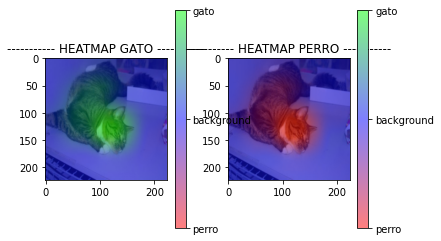

######################################################################
######################################################################
######################################################################
MIN: -0.0063870251178741455, MAX: 1.0
MIN: -0.8021568655967712, MAX: 6.761369877494872e-05
Y: tensor([[9.9987e-01, 1.3233e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB GradCAM:
	- GATO: 0.99987
	- PERRO: 0.00013
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


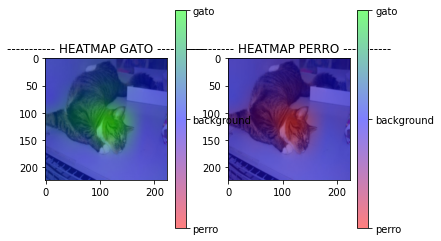

######################################################################
######################################################################
######################################################################
MIN: 0.06603854149580002, MAX: 1.0
MIN: -5.247984154266305e-05, MAX: 0.0013074117014184594
Y: tensor([[0.9959, 0.0041]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB GradCAM++:
	- GATO: 0.99589
	- PERRO: 0.00411
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


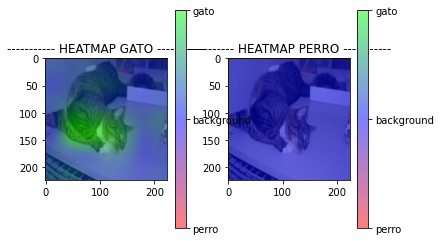

######################################################################
######################################################################
######################################################################
torch.Size([50, 512, 7, 7])
torch.Size([50, 512, 7, 7])
torch.Size([50, 512, 7, 7])
torch.Size([50, 512, 7, 7])
MIN: -0.11965568363666534, MAX: 1.0
MIN: -0.0006637554615736008, MAX: 0.0015256698243319988
Y: tensor([[9.9930e-01, 7.0125e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB SmoothGradCAM++:
	- GATO: 0.99930
	- PERRO: 0.00070
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


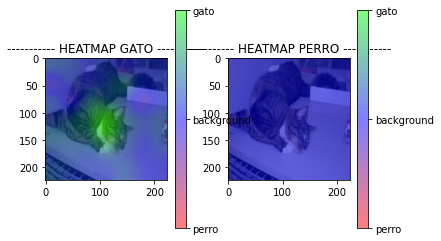

In [510]:
# Cogemos la activación de las capas
x, act_classes=next(iter(dataloader_test))
x=x.to(device)

act_classes=act_classes.to(device)



model_cam.plot_saliency_map(x, act_classes[0], -2)

print("#"*70)
print("#"*70)
print("#"*70)

model_gradcam.plot_saliency_map(x, act_classes[0], -2)

print("#"*70)
print("#"*70)
print("#"*70)

model_gradcampp.plot_saliency_map(x, act_classes[0], -2)

print("#"*70)
print("#"*70)
print("#"*70)

model_smoothgradcampp.plot_saliency_map(x, act_classes[0], class_plot=-2, n_noise=50, std=10)



(1077, 1077, 3)


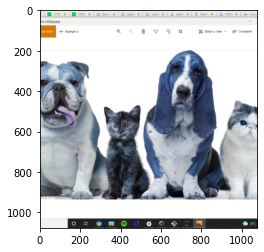

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 512, 7, 7])
torch.Size([100, 512, 7, 7])
torch.Size([100, 512, 7, 7])
torch.Size([100, 512, 7, 7])
MIN: 5.165234993192991e-12, MAX: 1.1911692465726986e-10
MIN: -0.3334231376647949, MAX: 1.0
Y: tensor([[1.6735e-10, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB SmoothGradCAM++:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


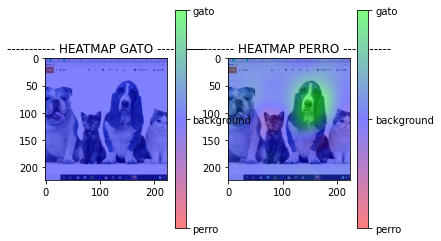

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 7, 7])
MIN: 5.726096246466694e-12, MAX: 2.281903277445707e-10
MIN: 0.0672718957066536, MAX: 1.0
Y: tensor([[3.7001e-10, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PROB SmoothGradCAM++:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- gato) vs (gato -- ACTUAL CLASS)


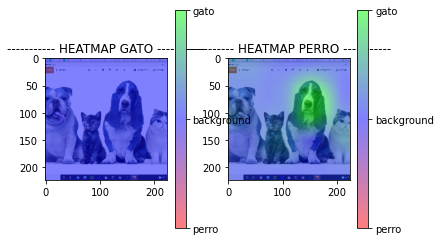

'\nmean = [0.485, 0.456, 0.406]\nvar = [0.229, 0.224, 0.225]\ndog_and_cat_plot=((torch.reshape(dog_and_cat.cpu(), (3,224,224)).permute(1,2,0).numpy())*var)+mean\nplt.imshow(dog_and_cat_plot)\nplt.show()\nprint(dog_and_cat_plot.shape)\n'

In [513]:
mean = [0.485, 0.456, 0.406]
var = [0.229, 0.224, 0.225]


#dog_and_cat = cv2.imread('dog_and_cat.jpeg')/255.
dog_and_cat = cv2.imread('dogs_and_cats2.png')/255.
#dog_and_cat = cv2.imread('cat2.jpg')/255.
#dog_and_cat = cv2.imread('dog2.jpg')/255.


print(dog_and_cat.shape)
plt.imshow(dog_and_cat)
plt.show()

dog_and_cat = (cv2.resize(dog_and_cat, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)-mean)/var


transform = torchvision.transforms.Compose([transforms.ToTensor()])
dog_and_cat = transform(dog_and_cat)
dog_and_cat = dog_and_cat.reshape((3,224,224))[None,:,:,:].float().to(device)


#model_gradcam.plot_saliency_map(dog_and_cat, act_classes[0], -2)
#model_gradcampp.plot_saliency_map(dog_and_cat, act_classes[0], -2)
model_smoothgradcampp.plot_saliency_map(dog_and_cat, act_classes[0], -2, n_noise=100, std=10)
model_smoothgradcampp.plot_saliency_map(dog_and_cat, act_classes[0], -2, n_noise=10, std=0.1)
"""
mean = [0.485, 0.456, 0.406]
var = [0.229, 0.224, 0.225]
dog_and_cat_plot=((torch.reshape(dog_and_cat.cpu(), (3,224,224)).permute(1,2,0).numpy())*var)+mean
plt.imshow(dog_and_cat_plot)
plt.show()
print(dog_and_cat_plot.shape)
"""

## PRUEBA GRADIENTES

In [512]:
t1=torch.tensor(1., requires_grad=True)
t2=torch.tensor(2., requires_grad=True)
t3=torch.tensor(3., requires_grad=True)
################################################

t4 = t1+t2
t5=t4*t3

t5.backward()
################################################

t1.grad=torch.zeros_like(t1)
t2.grad=torch.zeros_like(t2)
t3.grad=torch.zeros_like(t3)

t6= (t3+t1)
t7= t6*t2

t7.backward()

#############################################
print("#"*60)
a1 = torch.tensor([[[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]]],[[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]]],[[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]],[[1.,1.],[1.,1.]]]])
a2 = torch.tensor([2.,3.,4.])

print(a1.shape)
print(a2[None,:].shape)
print(a1.transpose(0,1).transpose(1,2).transpose(2,3).shape)
res = torch.matmul(a1,a2[None,:])
print(res)


############################################################
torch.Size([3, 3, 2, 2])
torch.Size([1, 3])
torch.Size([3, 2, 2, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x2 and 1x3)